# Hate speech NLP classification model

By William, Jacob & Luchas

Inspiration til valg af classifiers: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Import libaries

In [1]:
import matplotlib.pyplot as plt # Library til at visualisere data gennem fx. kordinatsystem
import pandas as pd
import numpy as np



import emoji # https://carpedm20.github.io/emoji/docs/ - Library som bla. kan bruges til at fjerne emojis fra tekst
import re # Skal måske ikke bruges længere, vi brugte den til gammel "twitter cleaner"?

import nltk # (Natural Language Toolkit), library til diverse opgaver, fx. word stemming og tokenization
from nltk.stem import WordNetLemmatizer # Library til lemmatizing af ord (fx. libraries -> library)
lemmetizer_output= WordNetLemmatizer()

stemmer = nltk.SnowballStemmer("english") # Skal måske ikke bruges længere, vi brugte den til gammel "twitter cleaner"?
from nltk.corpus import stopwords # Skal måske ikke bruges længere, vi brugte den til gammel "twitter cleaner"?
import string # Skal måske ikke bruges længere, vi brugte den til gammel "twitter cleaner"?

stopword=set(stopwords.words('english')) # Set, indeholder engelske stopwords

from sklearn.naive_bayes import MultinomialNB # Importerer Naive Bayes algoritme
from sklearn.svm import SVC # Importerer SVM algoritme

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation



from textblob import TextBlob #Library til textanalyse. Vi bruger det pt. til at få polarity/subjectivity fra sætninger

from wordcloud import WordCloud #https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
from PIL import Image #Bruges til Word cloud (som visualiserer de mest hyppige ord i datasæt)

import timeit # https://docs.python.org/3/library/timeit.html  - Library som bruges til at måle, hvor lang tid det tager at køre en kode "block" 


## Instantiate algoritmer der skal bruges

In [2]:
nb = MultinomialNB() # Instantiates Naives Bayes
svm = SVC(kernel='linear', probability=True) # Instantiates SVM, og sætter dens kernal til linear

### Import the dataset

In [3]:
data = pd.read_csv('C:/Users/Jacob/Bachelor/Data/generic_sentiment_small.csv') #https://www.kaggle.com/datasets/akgeni/generic-sentiment-multidomain-sentiment-dataset?select=generic_sentiment_dataset_50k.csv

## Function for cleaning text

In [4]:
# def clean(text):
#     text = str(text).lower()
#      #Denne fjerner RT @username, skal stå før "string.punctuation"
#     #text = re.sub('rt @\w+', '', text)
    
#      #Denne fjerner RT@username, skal stå før "string.punctuation". Tror den virker :)
#     #text = re.sub('rt@\w+', '', text)
    
    
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('http?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
    
#     #Denne fjerner @username, skal stå før "string.punctuation"
#     #text = re.sub(r'RT@\w+', '', text)
    
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)
#     text = [word for word in text.split(' ') if word not in stopword]
#     text=" ".join(text)
#     text = [stemmer.stem(word) for word in text.split(' ')]
#     text=" ".join(text)
#     return text

#### applies the cleaning function to text

In [5]:
#data["cleaned_text"] = data["text"].apply(clean)

### Fjerner alt fra "text", som ikke er store/små bogstaver. Fx. Ø, * eller !

In [6]:
data["text"] = data['text'].str.replace('[^a-zA-Z]',' ', regex=True)

### Bruger NLTK tokenizer, til at opdele sætninger til enkeltstående ord. Lambda = gennemgår alle sætninger i datasæt

In [7]:
data['clean_text'] = data['text'].apply(lambda x: nltk.word_tokenize(x) ) 

### Laver lemmatization for hvert ord i hver kolonne. Fx. løber bliver ændret til løb. Ignorerer engelske stopwords

In [8]:
data['stem_text'] = data['clean_text'].apply(lambda x: [lemmetizer_output.lemmatize(j) for j in x if not j in set(stopword)] )
#applying lemmatization to each word of every column 
#by using pandas apply method
#and checking for stop words at the same time

### Laver ny række i datasæt, med færdig tekst. Altså cleaned tekst, som kan bruges til at træne model

In [9]:
data['cleaned_text'] = data['stem_text'].apply(lambda x: ' '.join(x) ) 

### Viser datasæt, her kan vi nu se hhv. clean_text, stem_text og cleaned_text

In [10]:
data

,sentiment,text,label,clean_text,stem_text,cleaned_text
0,positive,good mobile battery is mah is very big ...,2,"[good, mobile, battery, is, mah, is, very, big...","[good, mobile, battery, mah, big, camera, qual...",good mobile battery mah big camera quality good
1,positive,Overall in hand ecpirience is quite good matt ...,2,"[Overall, in, hand, ecpirience, is, quite, goo...","[Overall, hand, ecpirience, quite, good, matt,...",Overall hand ecpirience quite good matt finish...
2,positive,Superb Camera No lag This is my firs...,2,"[Superb, Camera, No, lag, This, is, my, first,...","[Superb, Camera, No, lag, This, first, Samsung...",Superb Camera No lag This first Samsung phone ...
3,positive,Bigger size of application names doesn t allow...,2,"[Bigger, size, of, application, names, doesn, ...","[Bigger, size, application, name, allow, name,...",Bigger size application name allow name viewed...
4,negative,Just a hype of stock android which is not flaw...,0,"[Just, a, hype, of, stock, android, which, is,...","[Just, hype, stock, android, flawless, It, bet...",Just hype stock android flawless It better cus...
...,...,...,...,...,...,...
9933,neutral,Hi SCREEN the phone hz screen which is qu...,1,"[Hi, SCREEN, the, phone, hz, screen, which, is...","[Hi, SCREEN, phone, hz, screen, quite, fast, d...",Hi SCREEN phone hz screen quite fast depth col...
9934,negative,Even G data loading is very slow Poor camer...,0,"[Even, G, data, loading, is, very, slow, Poor,...","[Even, G, data, loading, slow, Poor, camera, q...",Even G data loading slow Poor camera quality E...
9935,positive,Battery drains fast please replace battery,2,"[Battery, drains, fast, please, replace, battery]","[Battery, drain, fast, please, replace, battery]",Battery drain fast please replace battery
9936,negative,The battery supposed to be Milli ampere b...,0,"[The, battery, supposed, to, be, Milli, ampere...","[The, battery, supposed, Milli, ampere, work, ...",The battery supposed Milli ampere work whole d...


### Fra emoji library. Tæller hvor mange emojis der er i "cleaned_text". 

In [11]:
emoji.emoji_count(data['cleaned_text'])

0

### Fjerner emojis. Måske overflødig, burde emojis ikke være fjernet?

In [12]:
data['cleaned_text'] = data['cleaned_text'].apply(lambda s: emoji.replace_emoji(s, ''))

In [13]:
emoji.emoji_count(data['cleaned_text'])

0

### Viser fordeling af kategorier til klassificering

<AxesSubplot:ylabel='sentiment'>

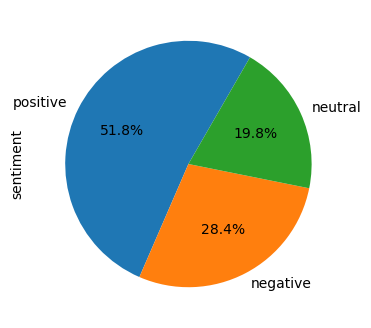

In [14]:
plt.figure(figsize=(4,4))
data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=60)

### Laver en wordcloud for at vise de ord, som går igen ofte i datasættet

In [15]:
# text_positive=data[data['label']==2]
# #text_positive
# text_positive_review = " ".join(label for label in text_positive.cleaned_text)
# #text_positive_review

# text_neutral=data[data['label']==1]
# #text_neutral
# text_neutral_review = " ".join(label for label in text_neutral.cleaned_text)
# #text_neutral_review

# text_negative=data[data['label']==0]
# #text_negative
# text_negative_review = " ".join(label for label in text_negative.cleaned_text)
# #text_negative_review


In [16]:
# wine_mask = np.array(Image.open("C:/Users/Jacob/Bachelor/Data/wordCloudTemplate.jpg"))
# wc = WordCloud(background_color="white", max_words=1000, mask=wine_mask,
#                 contour_width=3, contour_color='firebrick')

# # Generate a wordcloud
# wc.generate(text_positive_review)

# # store to file
# #wc.to_file("cloud2.png")

# # show
# plt.figure(figsize=[10,5])
# plt.imshow(wc)
# plt.axis("off")
# plt.title('Positive')
# plt.show()



# # Generate a wordcloud
# wc.generate(text_neutral_review)

# # store to file
# #wc.to_file("cloud2.png")

# # show
# plt.figure(figsize=[10,5])
# plt.imshow(wc)
# plt.axis("off")
# plt.title('Neutral')
# plt.show()

# # Generate a wordcloud
# wc.generate(text_negative_review)

# # store to file
# #wc.to_file("cloud2.png")

# # show
# plt.figure(figsize=[10,5])
# plt.imshow(wc)
# plt.axis("off")
# plt.title('Negative')
# plt.show()

### Bruger textblob library, som giver polarity (positiv/negativ), samt subjectivity (objektivt/subjektivt)

In [17]:
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment) # https://medium.com/analytics-vidhya/performing-sentiment-analysis-on-yelp-restaurant-reviews-962334d6336d
#applt textblob sentiment to yelp text column
#and assign it to a new column named polarity
sentiment_series = data['polarity'].tolist()

data[['polaarity','subjectivity']] = pd.DataFrame(sentiment_series, index=data.index)
data.drop('polarity', inplace=True, axis=1)
# split the list into two and create two new c
#split the list into two and create two new columns
#assign the return values of sentiment function;
#polarity and subjectivity to those columns

In [18]:
data

,sentiment,text,label,clean_text,stem_text,cleaned_text,polaarity,subjectivity
0,positive,good mobile battery is mah is very big ...,2,"[good, mobile, battery, is, mah, is, very, big...","[good, mobile, battery, mah, big, camera, qual...",good mobile battery mah big camera quality good,0.466667,0.433333
1,positive,Overall in hand ecpirience is quite good matt ...,2,"[Overall, in, hand, ecpirience, is, quite, goo...","[Overall, hand, ecpirience, quite, good, matt,...",Overall hand ecpirience quite good matt finish...,0.416667,0.429167
2,positive,Superb Camera No lag This is my firs...,2,"[Superb, Camera, No, lag, This, is, my, first,...","[Superb, Camera, No, lag, This, first, Samsung...",Superb Camera No lag This first Samsung phone ...,0.416667,0.611111
3,positive,Bigger size of application names doesn t allow...,2,"[Bigger, size, of, application, names, doesn, ...","[Bigger, size, application, name, allow, name,...",Bigger size application name allow name viewed...,0.175000,0.525000
4,negative,Just a hype of stock android which is not flaw...,0,"[Just, a, hype, of, stock, android, which, is,...","[Just, hype, stock, android, flawless, It, bet...",Just hype stock android flawless It better cus...,0.471429,0.600000
...,...,...,...,...,...,...,...,...
9933,neutral,Hi SCREEN the phone hz screen which is qu...,1,"[Hi, SCREEN, the, phone, hz, screen, which, is...","[Hi, SCREEN, phone, hz, screen, quite, fast, d...",Hi SCREEN phone hz screen quite fast depth col...,0.262500,0.700000
9934,negative,Even G data loading is very slow Poor camer...,0,"[Even, G, data, loading, is, very, slow, Poor,...","[Even, G, data, loading, slow, Poor, camera, q...",Even G data loading slow Poor camera quality E...,-0.162500,0.487500
9935,positive,Battery drains fast please replace battery,2,"[Battery, drains, fast, please, replace, battery]","[Battery, drain, fast, please, replace, battery]",Battery drain fast please replace battery,0.200000,0.600000
9936,negative,The battery supposed to be Milli ampere b...,0,"[The, battery, supposed, to, be, Milli, ampere...","[The, battery, supposed, Milli, ampere, work, ...",The battery supposed Milli ampere work whole d...,-0.150000,0.300000


### Variabler til input data og labels. 

In [19]:
X = np.array(data["cleaned_text"])
y = np.array(data["label"])

### Opdeler datasæt i træning og test. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

### Laver Vectorizers (omdanner tekst til vectors, som kan bruges til model) 

In [21]:
# vectorizer = CountVectorizer()
# X_train_vect = vectorizer.fit_transform(X_train)
# X_test_vect = vectorizer.transform(X_test)

### Viser hvordan Xtrain (tekst til træning), nu er repræsenteret som vector

In [22]:
#print(X_train_vect)

In [23]:
# VecWordsToDF=pd.DataFrame(X_train_vect.toarray(),columns=vectorizer.get_feature_names())
# VecWordsToDF.tail()

### Metoden "tokenize_test", bruges til at træne og teste samtlige algoritmer, så man kan sammenligne resultat

In [24]:
#models=[gbc,d,k,g,b,r,log,xgbc]
models=[nb, svm]
def tokenize_test(models,vect):
    row_list=[]
    for i in range(len(models)):
        X_train_vect = vect.fit_transform(X_train)
        X_test_vect = vect.transform(X_test)
        nb = models[i]
        nb.fit(X_train_vect, y_train)
        y_pred_class = nb.predict(X_test_vect)
        
        data={'accuracy_score':metrics.accuracy_score(y_test, y_pred_class)}
        
        if isinstance(nb, MultinomialNB):
            # Use predict_proba for MultinomialNB model
            # show the first few entries of predict_proba
            print("-------Naive Bayes--------")
            print("Predicted probabilities:\n{}".format(nb.predict_proba(X_test_vect)[:6]))
            # show that sums across rows are one
            print("Sums: {}".format(nb.predict_proba(X_test_vect)[:6].sum(axis=1)))
    
            #Ovenstående virker også, men giver tallene i Log (så vi kan ikke rigtigt sammenligne noget)
    
            print("Argmax of predicted probabilities:\n{}".format(
                np.argmax(nb.predict_proba(X_test_vect), axis=1)))
            print("Predictions:\n{}".format(nb.predict(X_test_vect)))
        else:
            print("-------SVM--------") #The probability model is created using cross validation, so the results can be slightly different than those obtained by predict.
            print("Predicted probabilities:\n{}".format(nb.predict_proba(X_test_vect)[:6]))
            # show that sums across rows are one
            print("Sums: {}".format(nb.predict_proba(X_test_vect)[:6].sum(axis=1)))
    
            #Ovenstående virker også, men giver tallene i Log (så vi kan ikke rigtigt sammenligne noget)
    
            print("Argmax of predicted probabilities:\n{}".format(
                np.argmax(nb.predict_proba(X_test_vect), axis=1)))
            print("Predictions:\n{}".format(nb.predict(X_test_vect)))
       
        
        row_list.append(data)
        #print ('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    df = pd.DataFrame(row_list, index =['nb', 'svm'])
    print(df) # printer dataframe, som viser de forskellige algoritmers accuracy_score 
    return df

In [25]:
vectCount = CountVectorizer(ngram_range=(1,2)) ## ngram_range, betyder her at CountVectorizer objekt både gemmer "single words" og bigrams (flere ord i træk)

vectTf = TfidfVectorizer(ngram_range=(1,2)) #Burde være bedre, men tager 8 min at compile med stort datasæt

#vectorizer = TfidfVectorizer(stop_words='english') - Fjerner stopwords, men har vi allerede gjort!

# Measure the time taken by the tokenize_test function (also executes it)
time_taken = timeit.timeit(lambda: tokenize_test(models, vectCount), number=1)

# Print the results
print(f"Tidsforbrug, ingen formatering:\n{time_taken}")
if time_taken < 60:
    print(f"\nTime taken: {round(time_taken, 2)} seconds")
elif time_taken < 3600:
    print(f"\nTime taken: {round(time_taken/60, 2)} minutes")
else:
    print(f"\nTime taken: {round(time_taken/3600, 2)} hours")


-------Naive Bayes--------
Predicted probabilities:
[[3.23992706e-03 1.18894943e-02 9.84870579e-01]
 [5.09099086e-02 8.07424912e-02 8.68347600e-01]
 [9.75695988e-01 1.53320728e-02 8.97193918e-03]
 [1.27354526e-05 5.40142791e-05 9.99933250e-01]
 [7.08798589e-12 3.07956140e-11 1.00000000e+00]
 [8.15545390e-05 9.76463610e-06 9.99908681e-01]]
Sums: [1. 1. 1. 1. 1. 1.]
Argmax of predicted probabilities:
[2 2 0 ... 0 2 1]
Predictions:
[2 2 0 ... 0 2 1]
-------SVM--------
Predicted probabilities:
[[0.09363227 0.21131169 0.69505604]
 [0.2454901  0.23029342 0.52421648]
 [0.57982514 0.2394877  0.18068715]
 [0.079128   0.20338063 0.71749137]
 [0.00994834 0.06573674 0.92431492]
 [0.064449   0.11956551 0.81598549]]
Sums: [1. 1. 1. 1. 1. 1.]
Argmax of predicted probabilities:
[2 2 0 ... 0 0 2]
Predictions:
[2 2 0 ... 0 0 2]
     accuracy_score
nb         0.701710
svm        0.671529
Tidsforbrug, ingen formatering:
40.758857

Time taken: 40.76 seconds


# Nedenstående er kode, hvor man selv kan indtaste sætning. I stedet for streamlit. Aka rodekasse :)

In [26]:
dataOtherTest = pd.read_csv('C:/Users/Jacob/Bachelor/Data/test_yelp.csv') #https://www.kaggle.com/datasets/thedevastator/yelp-reviews-sentiment-dataset

In [27]:
dataOtherTest["text"] = dataOtherTest["text"].apply(clean)

NameError: name 'clean' is not defined

In [ ]:
Xx = np.array(dataOtherTest["text"])
yy = np.array(dataOtherTest["label"])

Xx_vect = vectorizer.transform(Xx)

In [ ]:
yy_pred = nb_classifier.predict(Xx_vect)
print("Accuracy:", metrics.accuracy_score(yy_pred, yy))

In [ ]:
dataTest = pd.DataFrame(['It was truly amazing how derogatory the #GOPDebate was towards women. They didnt even try to apologize.'], 
                  columns=['text'])

In [ ]:
emoji.emoji_count(dataTest["text"])

In [ ]:
dataTest["text"] = dataTest["text"].apply(clean)

In [ ]:
dataTest["text"] = dataTest["text"].apply(lambda s: emoji.replace_emoji(s, ''))

In [ ]:
emoji.emoji_count(dataTest["text"])

In [ ]:
labelTest = np.array([1], dtype=np.int64)


In [ ]:
labelTest

In [ ]:
data_test_vect = vectorizer.transform(dataTest)

In [ ]:
dataPred = nb_classifier.predict(data_test_vect)
testAccuracy = np.mean(dataPred == labelTest)
print("Accuracy:", metrics.accuracy_score(dataPred, labelTest))
#print("Accuracy:", testAccuracy)

def detection():
    import streamlit as st
    st.title("Hate Speech Detection")
    user = st.text_area("Enter any Text: ")
    if len(user) < 1:
        st.write("  ")
    else:
        sample = user
        data = vectorizer.transform([sample]).toarray()
        a = dtree.predict(data)
        st.title(a)
detection()